## Visualize WoFCast Predictions

In [1]:
import sys, os 
sys.path.insert(0, os.path.dirname(os.path.dirname(os.getcwd())))

from wofscast.model import WoFSCastModel
from wofscast.border_mask import BORDER_MASK_NUMPY

from wofscast.data_generator import (load_chunk, 
                                     WRFZarrFileProcessor,
                                     WoFSDataProcessor, 
                                     dataset_to_input
                                    )
from wofscast import checkpoint
from wofscast.wofscast_task_config import (DBZ_TASK_CONFIG, 
                                           WOFS_TASK_CONFIG, 
                                           DBZ_TASK_CONFIG_1HR,
                                           DBZ_TASK_CONFIG_FULL
                                          )

In [2]:
# For plotting. 
import os
import numpy as np
import xarray 
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

from wofscast.plot import WoFSColors, WoFSLevels
from datetime import datetime
import pandas as pd

def to_datetimes(path, n_times = 13):  
    name, freq, ens_mem = os.path.basename(path).split('__')
    start_time_dt = datetime.strptime(name.split('_to')[0], 'wrfwof_%Y-%m-%d_%H%M%S')
    start_time = pd.Timestamp(start_time_dt)
    
    dt_list = pd.date_range(start=start_time, periods=n_times, freq=freq)
    return dt_list[2:]

# Assuming 'BORDER_MASK' is available and correctly sized for your 'preds' and 'tars'
def border_difference_check(preds, tars, border_mask):
    """Calculate the difference at the border and return a mask of differences."""
    border_diff = np.abs(preds - tars)
    # Apply the border mask to get differences only at the border
    border_diff_masked = np.where(border_mask, border_diff, np.nan)  # NaN where not border
    return np.nanmax(border_diff_masked)  # Get the maximum difference at the border

display_name_mapper = {'U' : 'U-wind Comp.', 
          'V' : 'V-wind Comp.', 
          'W' : 'Vert. Velocity',
          'T' : 'Pot. Temp.', 
          'GEOPOT' : 'Geopot. Height',
          'QVAPOR' : 'QVAPOR', 
          'T2' : '2-m Temp.', 
          'COMPOSITE_REFL_10CM' : 'Comp. Refl.',
          'UP_HELI_MAX' : '2-5 km UH', 
          'RAIN_AMOUNT' : 'Rain Rate'
         }

units_mapper = {'T': 'K', 
                'QVAPOR': 'kg/kg', 
                'T2': 'K', 
                'U': 'm/s', 
                'V': 'm/s', 
                'W': 'm/s', 
                'GEOPOT': 'm', 
                'RAIN_AMOUNT': 'in', 
                'COMPOSITE_REFL_10CM': 'dBZ'
               }

## Predict with WoFS-Cast

In [3]:
use_raw_zarr = False 

if use_raw_zarr: 

    base_path = '/work2/wofs_zarr/2021/20210503/2300/ENS_MEM_07'
    zarr_files = [os.path.join(base_path, f) for f in os.listdir(base_path)]
    zarr_files.sort()

    zarr_files = [zarr_files[::2][:14]]
    
    process_fn = preprocessor = WoFSDataProcessor()
    dataset = load_chunk(zarr_files, batch_over_time=True, gpu_batch_size=32, preprocess_fn=process_fn)
    
    dataset = dataset.compute()
else:
    base_path = '/work/mflora/wofs-cast-data/datasets_2hr_zarr/2021'
    #name = 'wrfwof_2021-05-13_230000_to_2021-05-14_011000__10min__ens_mem_05.nc'

    # Case I've kept showing everyone
    name = 'wrfwof_2021-05-15_020000_to_2021-05-15_041000__10min__ens_mem_09.zarr'

    # Early time of the case I've shown everyone
    #name = 'wrfwof_2021-05-15_000000_to_2021-05-15_021000__10min__ens_mem_09.zarr'

    # Messy Convection over TX
    #name = 'wrfwof_2021-05-07_210000_to_2021-05-07_231000__10min__ens_mem_15.nc'

    #name = 'wrfwof_2021-05-10_230000_to_2021-05-11_011000__10min__ens_mem_01.nc'
    path = os.path.join(base_path, name)
    
    dataset = load_chunk([path], batch_over_time=False, gpu_batch_size=32)
    dataset = dataset.compute() 

In [4]:
%%time 
#MODEL_PATH = '/work/mflora/wofs-cast-data/model/wofscast_baseline_full_v2.npz'
#MODEL_PATH = '/work/mflora/wofs-cast-data/model/wofscast_with_transformer.npz'
MODEL_PATH = '/work/mflora/wofs-cast-data/model/wofscast_baseline_mlp.npz'
#MODEL_PATH = '/work/mflora/wofs-cast-data/model/wofscast_dbz_1hr_v6.npz'

#MODEL_PATH = '/work/mflora/wofs-cast-data/model/wofscast_with_graphcast_weights_v1.npz'


#TODO: Add this to the saved data part, so that we load the correct norm stats 
norm_stats_path = '/work/mflora/wofs-cast-data/full_normalization_stats'
    
model = WoFSCastModel(norm_stats_path = norm_stats_path)
 
model.load_model(MODEL_PATH)
inputs, targets, forcings = dataset_to_input(dataset, model.task_config, 
                                             target_lead_times=slice('10min', '120min'), 
                                             batch_over_time=False, n_target_steps=12)

predictions = model.predict(inputs, targets, forcings)

CPU times: user 35.8 s, sys: 16.9 s, total: 52.7 s
Wall time: 12 s


In [5]:

class WoFSCastAnimator:
    def __init__(self, domain_size, plot_border=False, dts=None):
        self.dts = dts  # Placeholder, replace with your datetime conversion function
        self.plot_border = plot_border
        self.domain_size = domain_size
    
    def __call__(self, var, level, inputs, predictions, targets):
        self.var = var
        self.level = level
        self.inputs = inputs
        self.predictions = predictions
        self.targets = targets
    
        init_ds, pred, tars = self.drop_batch_dim(inputs, predictions, targets)
    
        level_txt = ''
        if level != 'none': 
            level_txt = f', level={level}'
    
        self.titles = [f'WoFS {display_name_mapper.get(var, var)}{level_txt}', 
                       f'WoFS-Cast {display_name_mapper.get(var, var)}{level_txt}']
    
        fig, self.axes = plt.subplots(dpi=200, figsize=(12, 6), ncols=2, 
                                      gridspec_kw={'height_ratios': [1], 'bottom': 0.15})
        
        plt.tight_layout()
    
        zs, levels = self.get_target_and_pred_pair(init_ds, init_ds, t=0, level=level, return_rng=True)
    
        self.cmap, self.levels = self.get_colormap_and_levels(var, levels)
    
        self.cbar_ax = fig.add_axes([0.15, 0.075, 0.7, 0.02])
        self.cbar = None
        
        self.fig = fig
        self.N = len(predictions.time)
    
        return FuncAnimation(fig, self.update, frames=self.N, interval=200)
    
    def drop_batch_dim(self, inputs, predictions, targets):
        dims = ('time', 'level', 'lat', 'lon')
        init_ds = inputs.squeeze(dim='batch', drop=True).isel(time=[-1]).transpose(*dims, missing_dims='ignore')
        preds = predictions.squeeze(dim='batch', drop=True).transpose(*dims, missing_dims='ignore')
        tars = targets.squeeze(dim='batch', drop=True).transpose(*dims, missing_dims='ignore')
    
        return init_ds, preds, tars
    
    def get_target_and_pred_pair(self, preds, targets, t, level=0, return_rng=False):
        if level == 'max':
            zs = [targets[self.var].isel(time=t).max(dim='level').values, 
                  preds[self.var].isel(time=t).max(dim='level').values]
        elif level == 'min': 
            zs = [targets[self.var].isel(time=t).min(dim='level').values, 
                  preds[self.var].isel(time=t).min(dim='level').values]
        elif level == 'none':
            zs = [targets[self.var].isel(time=t).values, 
                  preds[self.var].isel(time=t).values]
        else:
            zs = [targets[self.var].isel(time=t, level=level).values, 
                  preds[self.var].isel(time=t, level=level).values]
    
        if self.var == 'RAIN_AMOUNT':
            zs = [z / 25.4 for z in zs]
    
        if self.var == 'T2':
            zs = [(9.0 / 5.0 * (z - 273.15)) + 32.0 for z in zs]
    
        if return_rng:
            global_min = np.percentile(zs, 1)
            global_max = np.percentile(zs, 99)
            rng = np.linspace(global_min, global_max, 10)
            return zs, rng
    
        return zs 
    
    def get_colormap_and_levels(self, var, levels):
        if var == 'COMPOSITE_REFL_10CM':
            cmap = WoFSColors.nws_dz_cmap
            levels = WoFSLevels.dz_levels_nws
        elif var == 'RAIN_AMOUNT':
            cmap = WoFSColors.rain_cmap
            levels = WoFSLevels.rain_rate_levels
        elif var == 'UP_HELI_MAX':
            cmap = WoFSColors.wz_cmap_extend
            levels = WoFSLevels.uh_2to5_levels_3000m
        elif var == 'T2':
            cmap = WoFSColors.temp_cmap
            levels = np.arange(40., 90., 2.5)
        elif var == 'QVAPOR': 
            cmap = WoFSColors.temp_cmap
        elif var == 'W': 
            cmap = WoFSColors.wz_cmap_extend
            levels = [2.5, 5, 10, 15, 20, 25, 30, 35, 40]
        else:
            cmap = WoFSColors.wz_cmap_extend
        
        return cmap, levels
    
    def update(self, t):
        for ax in self.axes:
            ax.clear()

        if t == 0:
            zs = self.get_target_and_pred_pair(self.inputs, self.inputs, t=0, level=self.level)
        else:    
            zs = self.get_target_and_pred_pair(self.predictions, self.targets, t=t, level=self.level)
    
        rmse = np.sqrt(np.mean((zs[0] - zs[1])**2))

        try:
            u_pred, v_pred = self.predictions['U'][t].isel(level=0).values, self.predictions['V'][t].isel(level=0).values
            u_tar, v_tar = self.targets['U'][t].isel(level=0).values, self.targets['V'][t].isel(level=0).values 
            u_pred = u_pred[::5, ::5]
            v_pred = v_pred[::5, ::5]
            u_tar = u_tar[::5, ::5]
            v_tar = v_tar[::5, ::5]
            wind_pred = (u_pred, v_pred)
            wind_tar = (u_tar, v_tar)
            winds = [wind_tar, wind_pred]
            x, y = np.meshgrid(np.arange(self.domain_size), np.arange(self.domain_size))
            x = x[::5, ::5]
            y = y[::5, ::5]
        except:
            winds = [None, None]
    
        for i, (ax, z, wind) in enumerate(zip(self.axes, zs, winds)):
            
            z = z.squeeze() 
            
            if self.var in ['REFL_10CM', 'UP_HELI_MAX', 'COMPOSITE_REFL_10CM']:
                z = np.ma.masked_where(z < 1, z)

            im = ax.contourf(z, origin='lower', aspect='equal', cmap=self.cmap, levels=self.levels)
 
            try:
                u, v = wind
                ax.quiver(x, y, u, v, alpha=0.5)
            except:
                pass

            ax.set_title(self.titles[i], fontweight='bold')
            if i == 1:
                dis_name = display_name_mapper.get(self.var, self.var)
                ax.annotate(f'RMSE of {dis_name} ({units_mapper.get(self.var, self.var)}): {rmse:.4f}', 
                            xy=(0.01, 0.95), xycoords='axes fraction', 
                            weight='bold', color='red', 
                            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

            ax.annotate(f'Time: {self.dts[t]}', xy=(0.01, 0.01), xycoords='axes fraction', 
                        weight='bold', color='red', fontsize=10, 
                        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

            if self.cbar is None:
                self.cbar = self.fig.colorbar(im, cax=self.cbar_ax, orientation='horizontal')
                self.cbar.set_label(f'{display_name_mapper.get(self.var, self.var)} ({units_mapper.get(self.var, self.var)})')


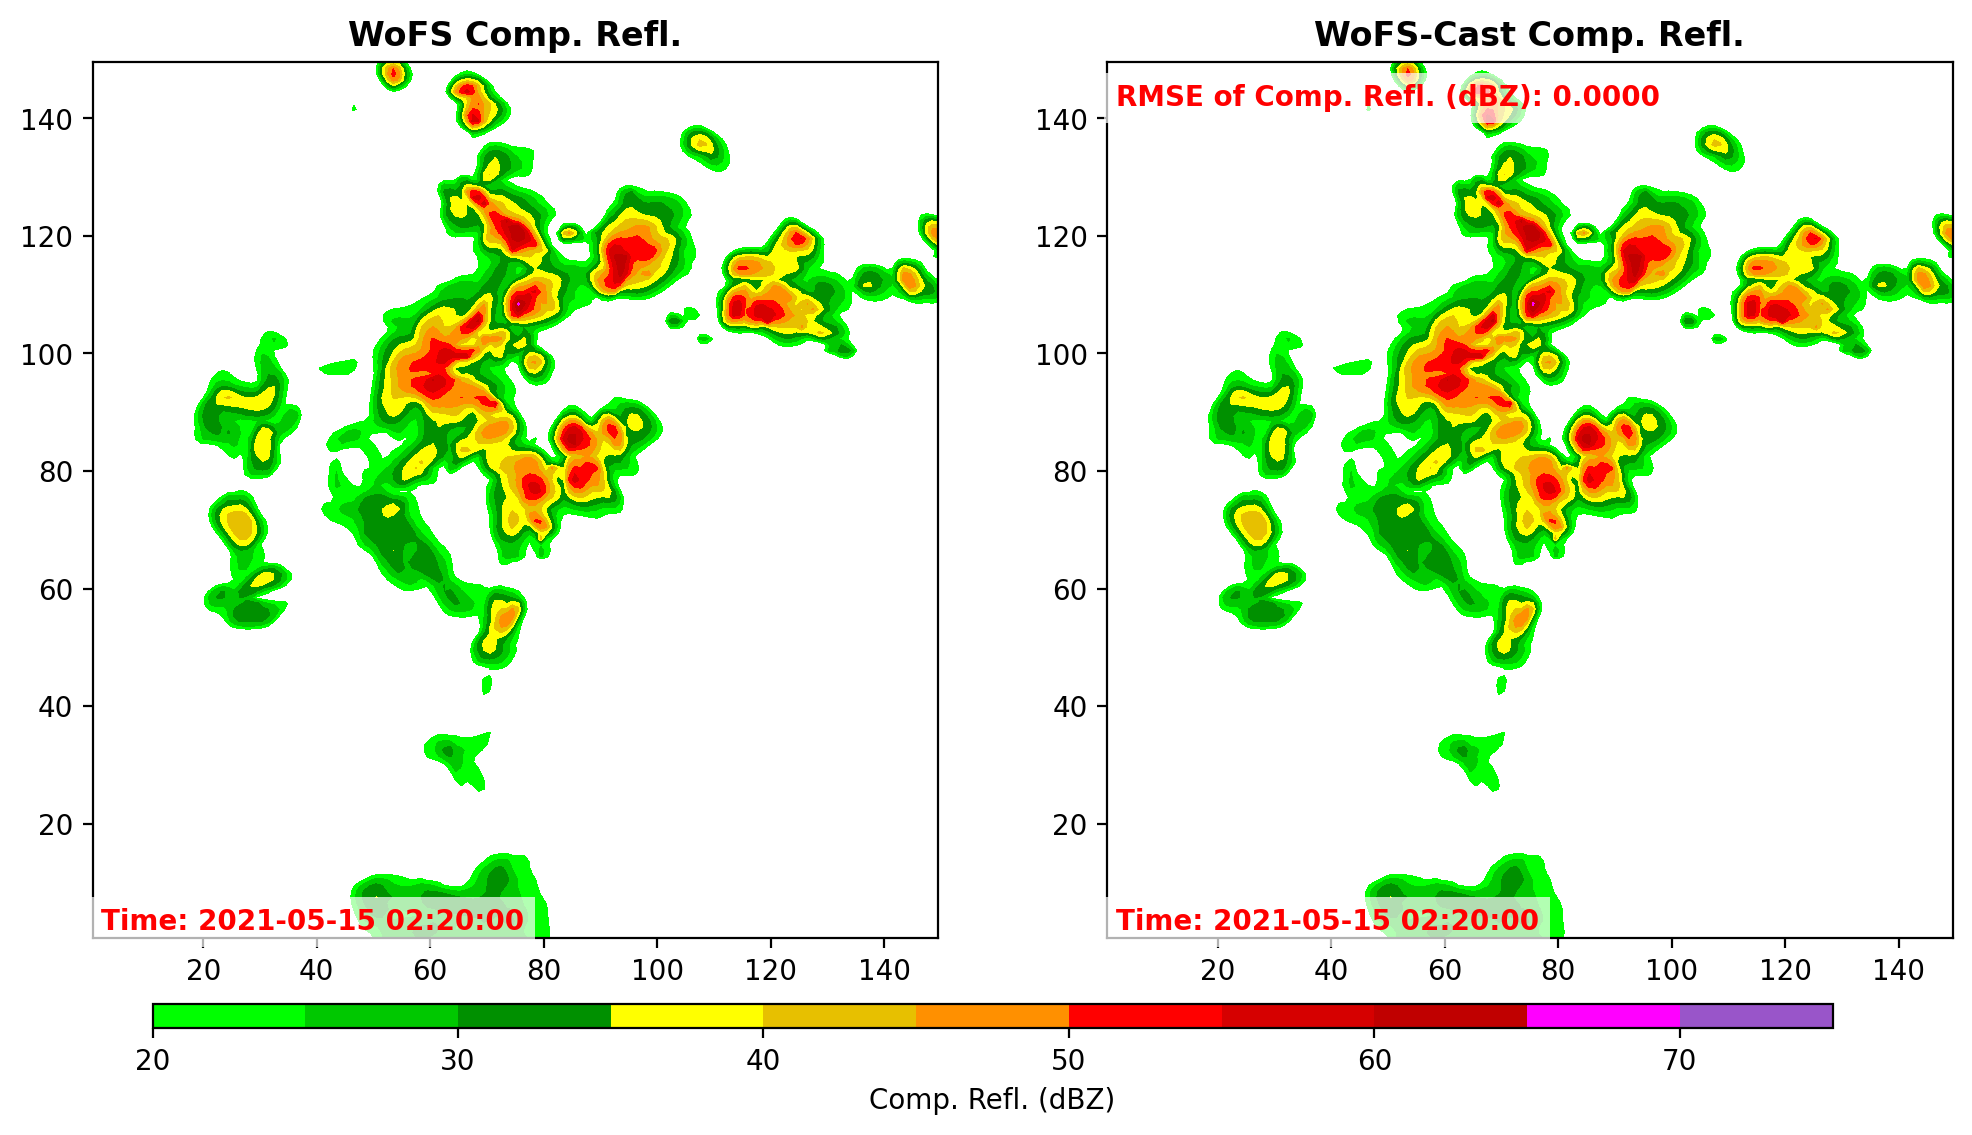

In [6]:
dts = to_datetimes(path, n_times = 14)

animator = WoFSCastAnimator(domain_size=150, dts=dts)
anim = animator(var='COMPOSITE_REFL_10CM', 
                level='none',
                inputs=inputs, 
                predictions=predictions, 
                targets=targets)

# To display the animation in a Jupyter notebook
from IPython.display import HTML
HTML(anim.to_jshtml())

# Optionally, to save the animation
#anim.save("wofscast.gif", writer="pillow", fps=3)   